# DAY 49

## cbam模块介绍

cbam注意力

之前我们介绍了se通道注意力，我们说所有的模块本质上只是对特征进一步提取，今天进一步介绍cbam注意力


CBAM 是一种能够集成到任何卷积神经网络架构中的注意力模块。它的核心目标是通过学习的方式，自动获取特征图在通道和空间维度上的重要性，进而对特征图进行自适应调整，增强重要特征，抑制不重要特征，提升模型的特征表达能力和性能。简单来说，它就像是给模型装上了 “智能眼镜”，让模型能够更精准地看到图像中关键的部分


CBAM 由两个主要部分组成：通道注意力模块（Channel Attention Module）和空间注意力模块（Spatial Attention Module）。这两个模块顺序连接，共同作用于输入的特征图。

SE 通道注意力的局限：仅关注 “哪些通道重要”，未考虑 “重要信息在空间中的位置”。
CBAM 的突破：
通道注意力（Channel Attention）：分析 “哪些通道的特征更关键”（如图像中的颜色、纹理通道）。
空间注意力（Spatial Attention）：定位 “关键特征在图像中的具体位置”（如物体所在区域）。
二者结合：让模型同时学会 “关注什么” 和 “关注哪里”，提升特征表达能力。


输入特征图 → 通道注意力模块 → 空间注意力模块 → 输出增强后的特征图

轻量级设计：仅增加少量计算量（全局池化 + 简单卷积），适合嵌入各种 CNN 架构（如 ResNet、YOLO）。
即插即用：无需修改原有模型主体结构，直接作为模块插入卷积层之间。
双重优化：同时提升通道和空间维度的特征质量，尤其适合复杂场景（如小目标检测、语义分割）。

这些模块相较于cnn都属于即插即用

In [5]:
import torch
import torch.nn as nn

# 定义通道注意力
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        """
        通道注意力机制初始化
        参数:
            in_channels: 输入特征图的通道数
            ratio: 降维比例，用于减少参数量，默认为16
        """
        super().__init__()
        # 全局平均池化，将每个通道的特征图压缩为1x1，保留通道间的平均值信息
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # 全局最大池化，将每个通道的特征图压缩为1x1，保留通道间的最显著特征
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        # 共享全连接层，用于学习通道间的关系
        # 先降维（除以ratio），再通过ReLU激活，最后升维回原始通道数
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // ratio, bias=False),  # 降维层
            nn.ReLU(),  # 非线性激活函数
            nn.Linear(in_channels // ratio, in_channels, bias=False)   # 升维层
        )
        # Sigmoid函数将输出映射到0-1之间，作为各通道的权重
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        前向传播函数
        参数:
            x: 输入特征图，形状为 [batch_size, channels, height, width]
        返回:
            调整后的特征图，通道权重已应用
        """
        # 获取输入特征图的维度信息，这是一种元组的解包写法
        b, c, h, w = x.shape
        # 对平均池化结果进行处理：展平后通过全连接网络
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        # 对最大池化结果进行处理：展平后通过全连接网络
        max_out = self.fc(self.max_pool(x).view(b, c))
        # 将平均池化和最大池化的结果相加并通过sigmoid函数得到通道权重
        attention = self.sigmoid(avg_out + max_out).view(b, c, 1, 1)
        # 将注意力权重与原始特征相乘，增强重要通道，抑制不重要通道
        return x * attention #这个运算是pytorch的广播机制

In [6]:
## 空间注意力模块
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 通道维度池化
        avg_out = torch.mean(x, dim=1, keepdim=True)  # 平均池化：(B,1,H,W)
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # 最大池化：(B,1,H,W)
        pool_out = torch.cat([avg_out, max_out], dim=1)  # 拼接：(B,2,H,W)
        attention = self.conv(pool_out)  # 卷积提取空间特征
        return x * self.sigmoid(attention)  # 特征与空间权重相乘

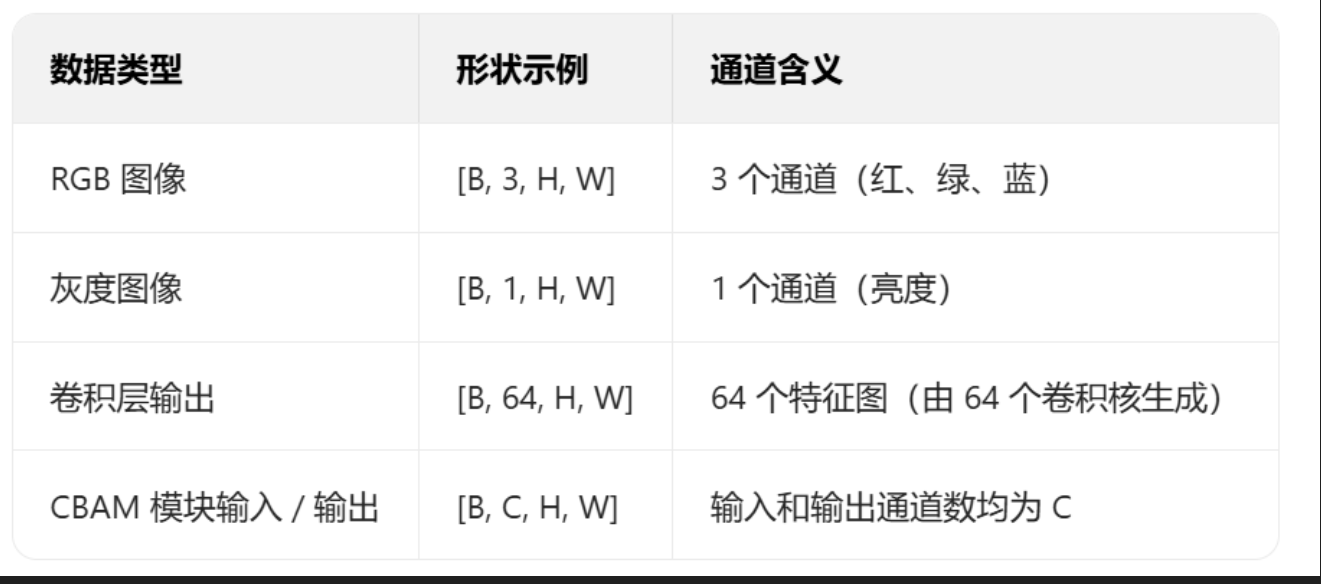

In [7]:
## CBAM模块
class CBAM(nn.Module):
    def __init__(self, in_channels, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attn = ChannelAttention(in_channels, ratio)
        self.spatial_attn = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_attn(x)
        x = self.spatial_attn(x)
        return x

可以看到CBAM就是通道注意力+空间注意力，二者的输出是串行的

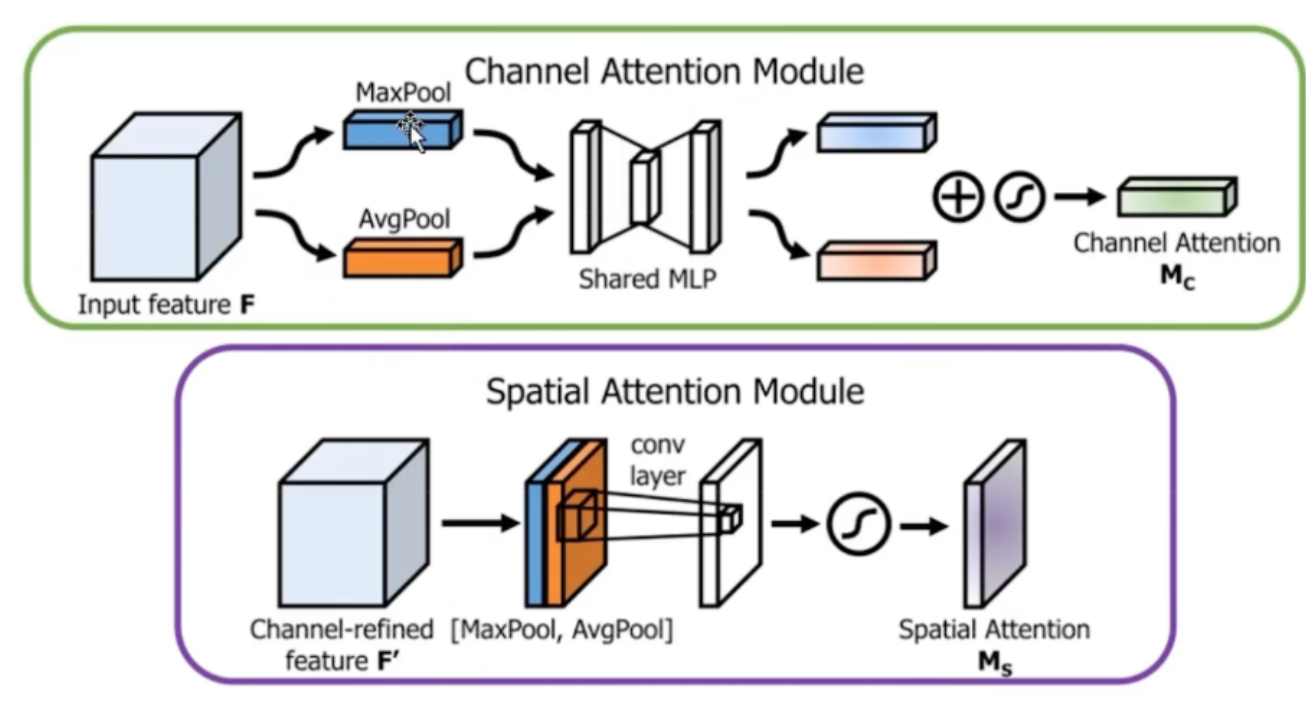

In [8]:
# 测试下通过CBAM模块的维度变化
# 输入卷积的尺寸为
# 假设输入特征图：batch=2，通道=512，尺寸=26x26
x = torch.randn(2, 512, 26, 26) 
cbam = CBAM(in_channels=512)
output = cbam(x)  # 输出形状不变：(2, 512, 26, 26)
print(f"Output shape: {output.shape}")  # 验证输出维度

Output shape: torch.Size([2, 512, 26, 26])


## cnn+cbam训练

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体支持
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 数据预处理（与原代码一致）
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 加载数据集（与原代码一致）
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

使用设备: cuda
Files already downloaded and verified


In [ ]:
# 定义带有CBAM的CNN模型
class CBAM_CNN(nn.Module):
    def __init__(self):
        super(CBAM_CNN, self).__init__()
        
        # ---------------------- 第一个卷积块（带CBAM） ----------------------
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # 批归一化
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.cbam1 = CBAM(in_channels=32)  # 在第一个卷积块后添加CBAM
        
        # ---------------------- 第二个卷积块（带CBAM） ----------------------
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.cbam2 = CBAM(in_channels=64)  # 在第二个卷积块后添加CBAM
        
        # ---------------------- 第三个卷积块（带CBAM） ----------------------
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.cbam3 = CBAM(in_channels=128)  # 在第三个卷积块后添加CBAM
        
        # ---------------------- 全连接层 ----------------------
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # 第一个卷积块
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.cbam1(x)  # 应用CBAM
        
        # 第二个卷积块
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.cbam2(x)  # 应用CBAM
        
        # 第三个卷积块
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.cbam3(x)  # 应用CBAM
        
        # 全连接层
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# 初始化模型并移至设备
model = CBAM_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

开始使用带CBAM的CNN训练模型...
Epoch: 1/50 | Batch: 100/782 | 单Batch损失: 1.8068 | 累计平均损失: 1.9504
Epoch: 1/50 | Batch: 200/782 | 单Batch损失: 1.6703 | 累计平均损失: 1.8310
Epoch: 1/50 | Batch: 300/782 | 单Batch损失: 1.7282 | 累计平均损失: 1.7603
Epoch: 1/50 | Batch: 400/782 | 单Batch损失: 1.4028 | 累计平均损失: 1.7050
Epoch: 1/50 | Batch: 500/782 | 单Batch损失: 1.2384 | 累计平均损失: 1.6675
Epoch: 1/50 | Batch: 600/782 | 单Batch损失: 1.3262 | 累计平均损失: 1.6308
Epoch: 1/50 | Batch: 700/782 | 单Batch损失: 1.2315 | 累计平均损失: 1.5930
Epoch 1/50 完成 | 训练准确率: 42.49% | 测试准确率: 58.60%
Epoch: 2/50 | Batch: 100/782 | 单Batch损失: 1.1333 | 累计平均损失: 1.3602
Epoch: 2/50 | Batch: 200/782 | 单Batch损失: 1.2330 | 累计平均损失: 1.3296
Epoch: 2/50 | Batch: 300/782 | 单Batch损失: 0.9225 | 累计平均损失: 1.2934
Epoch: 2/50 | Batch: 400/782 | 单Batch损失: 0.9983 | 累计平均损失: 1.2701
Epoch: 2/50 | Batch: 500/782 | 单Batch损失: 1.0356 | 累计平均损失: 1.2461
Epoch: 2/50 | Batch: 600/782 | 单Batch损失: 1.0236 | 累计平均损失: 1.2341
Epoch: 2/50 | Batch: 700/782 | 单Batch损失: 1.2743 | 累计平均损失: 1.2210
Epoch 2/50 完成 | 训练准确率: 

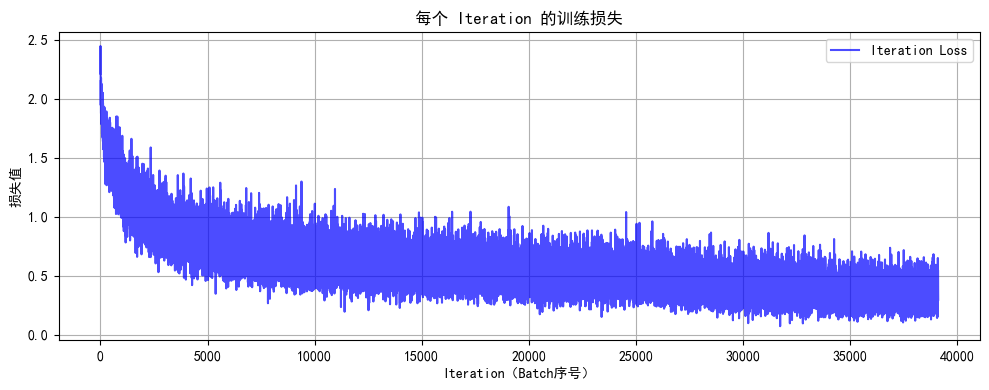

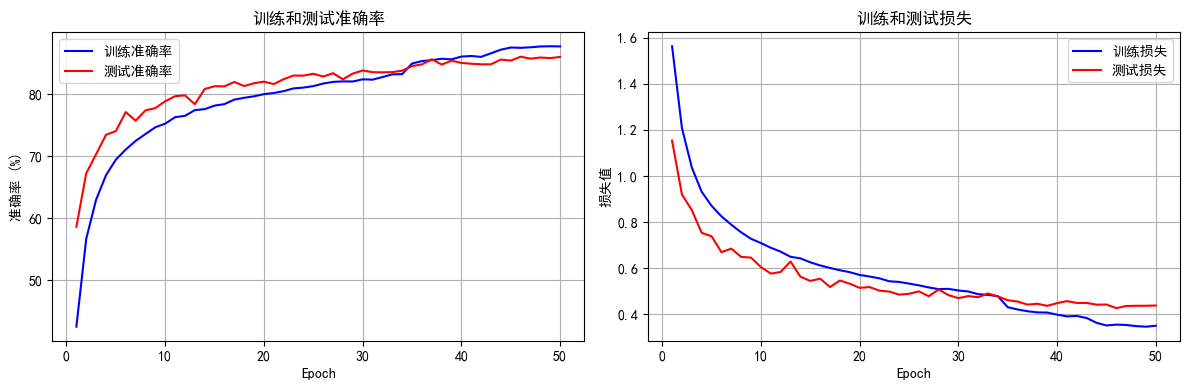

训练完成！最终测试准确率: 85.98%


In [11]:
# 训练函数
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    model.train()
    all_iter_losses = []
    iter_indices = []
    train_acc_history = []
    test_acc_history = []
    train_loss_history = []
    test_loss_history = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            iter_loss = loss.item()
            all_iter_losses.append(iter_loss)
            iter_indices.append(epoch * len(train_loader) + batch_idx + 1)
            
            running_loss += iter_loss
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch_idx+1}/{len(train_loader)} '
                      f'| 单Batch损失: {iter_loss:.4f} | 累计平均损失: {running_loss/(batch_idx+1):.4f}')
        
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct / total
        train_acc_history.append(epoch_train_acc)
        train_loss_history.append(epoch_train_loss)
        
        # 测试阶段
        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()
        
        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100. * correct_test / total_test
        test_acc_history.append(epoch_test_acc)
        test_loss_history.append(epoch_test_loss)
        
        scheduler.step(epoch_test_loss)
        
        print(f'Epoch {epoch+1}/{epochs} 完成 | 训练准确率: {epoch_train_acc:.2f}% | 测试准确率: {epoch_test_acc:.2f}%')
    
    plot_iter_losses(all_iter_losses, iter_indices)
    plot_epoch_metrics(train_acc_history, test_acc_history, train_loss_history, test_loss_history)
    
    return epoch_test_acc

# 绘图函数
def plot_iter_losses(losses, indices):
    plt.figure(figsize=(10, 4))
    plt.plot(indices, losses, 'b-', alpha=0.7, label='Iteration Loss')
    plt.xlabel('Iteration（Batch序号）')
    plt.ylabel('损失值')
    plt.title('每个 Iteration 的训练损失')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_epoch_metrics(train_acc, test_acc, train_loss, test_loss):
    epochs = range(1, len(train_acc) + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-', label='训练准确率')
    plt.plot(epochs, test_acc, 'r-', label='测试准确率')
    plt.xlabel('Epoch')
    plt.ylabel('准确率 (%)')
    plt.title('训练和测试准确率')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-', label='训练损失')
    plt.plot(epochs, test_loss, 'r-', label='测试损失')
    plt.xlabel('Epoch')
    plt.ylabel('损失值')
    plt.title('训练和测试损失')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 执行训练
epochs = 50
print("开始使用带CBAM的CNN训练模型...")
final_accuracy = train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs)
print(f"训练完成！最终测试准确率: {final_accuracy:.2f}%")

# # 保存模型
# torch.save(model.state_dict(), 'cifar10_cbam_cnn_model.pth')
# print("模型已保存为: cifar10_cbam_cnn_model.pth")